In [1]:
# 이미지 파일로 폴더에 저장
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

# 저장 경로
base_dir = "/home/parkwooyeol/workspace/Python Practice/ML/MNIST"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# 폴더 생성
for i in range(10):
    os.makedirs(os.path.join(train_dir, str(i)), exist_ok=True)
    os.makedirs(os.path.join(test_dir, str(i)), exist_ok=True)

# MNIST 로드
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root=base_dir, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=base_dir, train=False, transform=transform, download=True)

# train 저장
for idx, (img, label) in enumerate(train_dataset):
    path = os.path.join(train_dir, str(label), f"{idx}.png")
    save_image(img, path)

# test 저장
for idx, (img, label) in enumerate(test_dataset):
    path = os.path.join(test_dir, str(label), f"{idx}.png")
    save_image(img, path)



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ----------------------------
# 1. 데이터 로드
# ----------------------------
base_dir = "/home/parkwooyeol/workspace/Python Practice/ML/MNIST"
train_dir = f"{base_dir}/train"
test_dir = f"{base_dir}/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [3]:
#  train/validation 나누기
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 2. 학습 및 테스트 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=2):
    model = model.to(device)
    train_losses, val_losses, val_accs = [], [], []

    best_val_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Val Acc={val_acc:.2f}%")

        # Early Stopping 체크 (patience=2)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    return train_losses, val_losses, val_accs

In [5]:
# 3. CASE 1: 마지막 레이어 제거 후 새 Linear 추가
vgg_case1 = models.vgg16(pretrained=True)
vgg_case1.classifier = nn.Sequential(*list(vgg_case1.classifier.children())[:-1])  # 마지막 레이어 제거
vgg_case1.classifier.add_module("6", nn.Linear(4096, 10))  # MNIST 10 클래스

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_case1.parameters(), lr=0.0001)

print("=== CASE 1 ===")
train_losses1, val_losses1, val_accs1 = train_model(vgg_case1, train_loader, val_loader, criterion, optimizer)

/home/parkwooyeol/workspace/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/parkwooyeol/workspace/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== CASE 1 ===
Epoch 1: Train Loss=0.0853, Val Loss=0.0372, Val Acc=98.83%
Epoch 2: Train Loss=0.0315, Val Loss=0.0315, Val Acc=99.08%
Epoch 3: Train Loss=0.0213, Val Loss=0.0231, Val Acc=99.38%
Epoch 4: Train Loss=0.0181, Val Loss=0.0432, Val Acc=98.94%
Epoch 5: Train Loss=0.0155, Val Loss=0.0250, Val Acc=99.31%
Early stopping triggered after 5 epochs


In [6]:
# 4. CASE 2: 기존 classifier 유지 + 마지막 레이어만 MNIST 10 클래스
vgg_case2 = models.vgg16(pretrained=True)
vgg_case2.classifier[6] = nn.Linear(4096, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_case2.parameters(), lr=0.0001)

print("=== CASE 2 ===")
train_losses2, val_losses2, val_accs2 = train_model(vgg_case2, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=2)

=== CASE 2 ===
Epoch 1: Train Loss=0.0828, Val Loss=0.0354, Val Acc=98.92%
Epoch 2: Train Loss=0.0278, Val Loss=0.0273, Val Acc=99.13%
Epoch 3: Train Loss=0.0198, Val Loss=0.0268, Val Acc=99.21%
Epoch 4: Train Loss=0.0180, Val Loss=0.0378, Val Acc=98.98%
Epoch 5: Train Loss=0.0129, Val Loss=0.0277, Val Acc=99.23%
Epoch 6: Train Loss=0.0146, Val Loss=0.0258, Val Acc=99.29%
Epoch 7: Train Loss=0.0116, Val Loss=0.0295, Val Acc=99.18%
Epoch 8: Train Loss=0.0094, Val Loss=0.0300, Val Acc=99.38%
Epoch 9: Train Loss=0.0095, Val Loss=0.0226, Val Acc=99.45%
Epoch 10: Train Loss=0.0094, Val Loss=0.0325, Val Acc=99.32%


In [7]:
# 5. CASE 3: pretrained conv freeze + CASE2 마지막 레이어만 학습
vgg_case3 = models.vgg16(pretrained=True)
vgg_case3.classifier[6] = nn.Linear(4096, 10)

# conv 레이어 freeze
for param in vgg_case3.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg_case3.parameters()), lr=0.0001)

print("=== CASE 3 ===")
train_losses3, val_losses3, val_accs3 = train_model(vgg_case3, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=2)

=== CASE 3 ===
Epoch 1: Train Loss=0.1116, Val Loss=0.0392, Val Acc=98.77%
Epoch 2: Train Loss=0.0320, Val Loss=0.0362, Val Acc=98.86%
Epoch 3: Train Loss=0.0218, Val Loss=0.0390, Val Acc=98.85%
Epoch 4: Train Loss=0.0158, Val Loss=0.0570, Val Acc=98.62%
Early stopping triggered after 4 epochs


In [ ]:
# 각 모델 파라미터수 비교
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

for i, model in enumerate([vgg_case1, vgg_case2, vgg_case3], 1):
    total, trainable = count_params(model)
    print(f"CASE{i} - Total params: {total}, Trainable params: {trainable}")

CASE1 - Total params: 134301514, Trainable params: 134301514
CASE2 - Total params: 134301514, Trainable params: 134301514
CASE3 - Total params: 134301514, Trainable params: 119586826


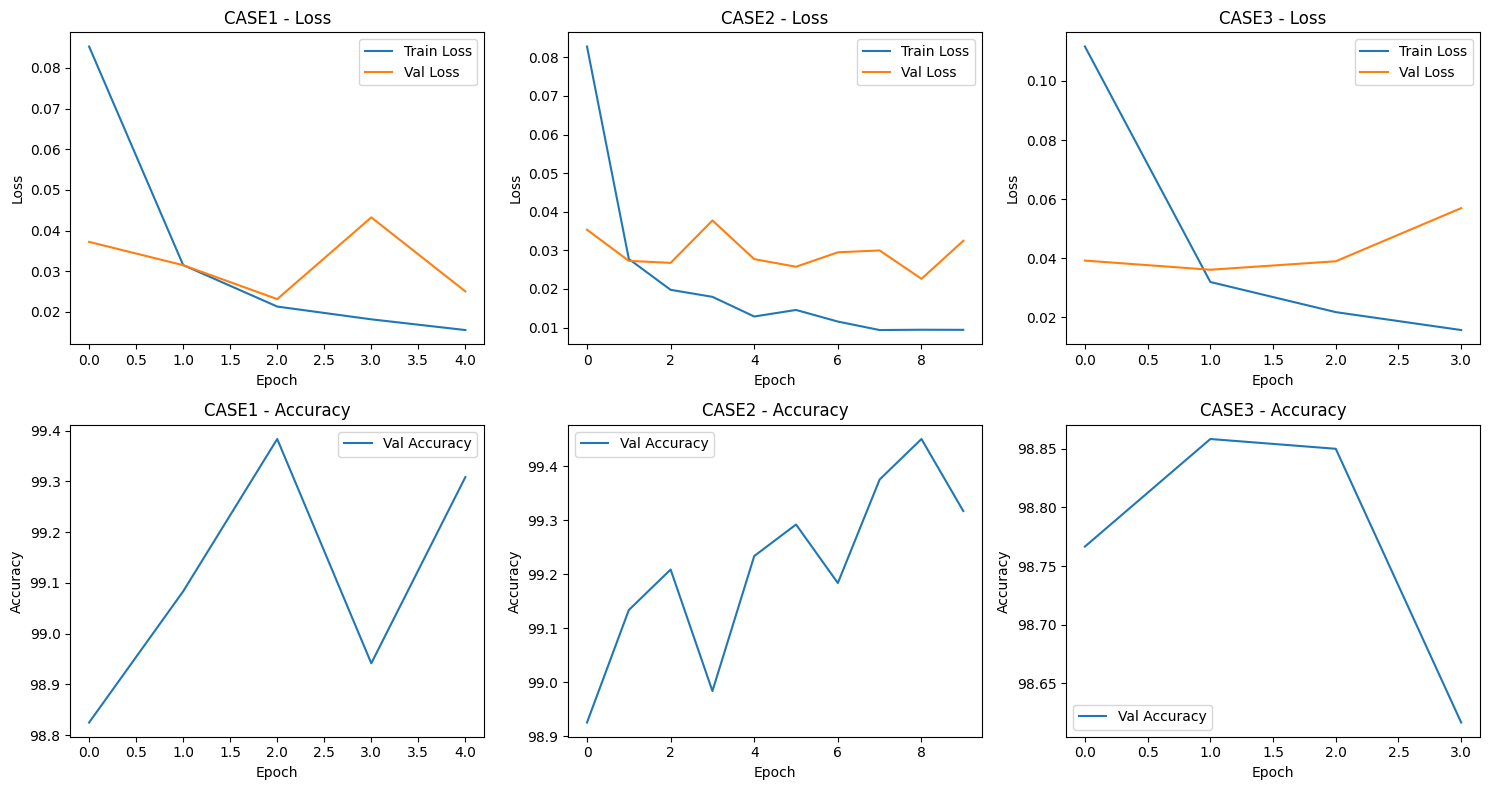

In [16]:
# 6. 결과 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2행 3열

# CASE 1
axes[0, 0].plot(train_losses1, label="Train Loss")
axes[0, 0].plot(val_losses1, label="Val Loss")
axes[0, 0].set_title("CASE1 - Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

axes[1, 0].plot(val_accs1, label="Val Accuracy")
axes[1, 0].set_title("CASE1 - Accuracy")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].legend()

# CASE 2
axes[0, 1].plot(train_losses2, label="Train Loss")
axes[0, 1].plot(val_losses2, label="Val Loss")
axes[0, 1].set_title("CASE2 - Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

axes[1, 1].plot(val_accs2, label="Val Accuracy")
axes[1, 1].set_title("CASE2 - Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].legend()

# CASE 3
axes[0, 2].plot(train_losses3, label="Train Loss")
axes[0, 2].plot(val_losses3, label="Val Loss")
axes[0, 2].set_title("CASE3 - Loss")
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Loss")
axes[0, 2].legend()

axes[1, 2].plot(val_accs3, label="Val Accuracy")
axes[1, 2].set_title("CASE3 - Accuracy")
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel("Accuracy")
axes[1, 2].legend()

plt.tight_layout()
plt.show()